# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [1]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import numpy as np
import shutil
import tensorflow as tf
from transformers import pipeline

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# matplotlib settings
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Dataset

In [6]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [7]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [8]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [10]:
# data examples
for review, label in train_ds.take(1):
    for i in range(5):
        print(f"\nReview: {review[i]}")
        print(f"Label: {class_labels[label[i]]}: ({label[i]})")


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: neg: (0)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

## Inference

Map review sentiment predictions to the sentiment range from -1 to 1: from negative (-1), neutral(0), to positive(+1).

In [11]:
# helper functions
def make_prediction(raw_review, model):
    """Args: 
    - raw_review: a single review of str type;
    - model: fine-tuned model.
    Outputs:
    - sentiment: a scalar that maps predicted review sentiments
    to fall into range [-1, 1]."""
    # convert a raw review into a tensor + batch dimension
    review = tf.expand_dims(tf.constant(raw_review), axis=0)
    # 2 neurons in the output layer, take the output of only 1 of them
    pred = model.predict(review, verbose=0)[:, 1]
    sentiment = tf.nn.tanh(pred)
    return sentiment.numpy()

def plot_bar(prediction):
    """Given a single scalar prediction plots it in a 
    colormap of a range [-1, 1]."""
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    ticks = ["negative", "neutral", "positive"]
    bounds = [-1., 0.0, 1.0]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='horizontal')
    cb1.ax.axvline(prediction, c='green', linewidth=3)
    cb1.ax.text(prediction, 1.1, s="prediction: "+str(round(prediction[0], 2)), 
                horizontalalignment="center", fontsize=9, c="green")
    cb1.set_ticklabels(ticks)
    cb1.set_label('Sentiment Scale')

In [12]:
model = tf.keras.models.load_model("bert_tiny.keras")

/home/omarchevska/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/home/omarchevska/miniconda3/envs/ml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 84 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Review: This movies was wonderful, however the music was not that good.


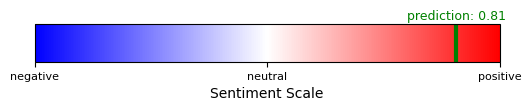

In [26]:
# test model prediction and plot result
review = "This movies was wonderful, however the music was not that good."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: It was okay, 5 out of 10, but i wouldn't watch it again.


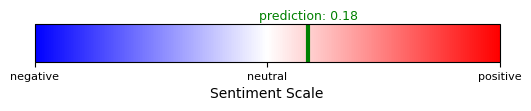

In [27]:
review = "It was okay, 5 out of 10, but i wouldn't watch it again."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: Movie is completely awful!


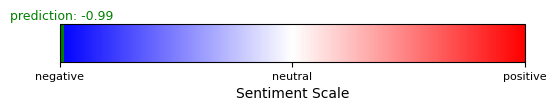

In [28]:
review = "Movie is completely awful!"
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: tf.Tensor(b'The remarkable, sometimes infuriating, often brilliant films of John Cassavetes occupy a unique position in American cinema\xc2\x85 Low-budget, partly improvised, inspired by cin\xc3\xa9ma verit\xc3\xa9 documentary, and related to underground film, they have nevertheless frequently managed to reach a wide and profoundly appreciative audience\xc2\x85 <br /><br />After drama studies, the young Cassavetes quickly made his name as an unusually unrefined, intense actor, often appearing in films about disaffected, rebellious youth such as "Crime in the Streets" and "Edge of the City." <br /><br />Setting up an actors\' workshop, he worked to transform an improvisational experiment into his feature debut\xc2\x85 The result, "Shadows," taking three years to complete and partly financed by his performances in TV\'s Johnny Staccato, was a breakthrough in American cinema\xc2\x85 About the effect of racism on an already fraught relationship between two black men and their siste

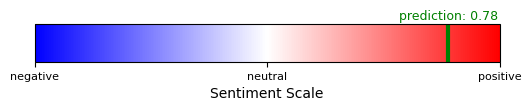

In [29]:
# test review from the test set
review_label = test_ds.unbatch().take(1)
for review, label in review_label:
    print("Review:", review)
    print("True label:", label.numpy())
    plot_bar(make_prediction(review, model))

## Error Analysis

In [406]:
# get true and predicted labels
y_true = tf.stack([label for _, label in test_ds.unbatch()], axis=0)
# raw model outputs
logits = model_1.predict(test_ds, verbose=0)
# class probabilities
y_proba = tf.nn.softmax(logits)
# predicted labels
y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)

print("Labels:", y_true)
print("Predictions:", y_pred)

Labels: tf.Tensor([0 0 1 ... 1 0 1], shape=(25000,), dtype=int32)
Predictions: tf.Tensor([0 0 1 ... 0 0 1], shape=(25000,), dtype=int32)


In [407]:
# utility functions to plot confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(3, 3)})
    ax.set_title('Confusion matrix of sentiment prediction for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

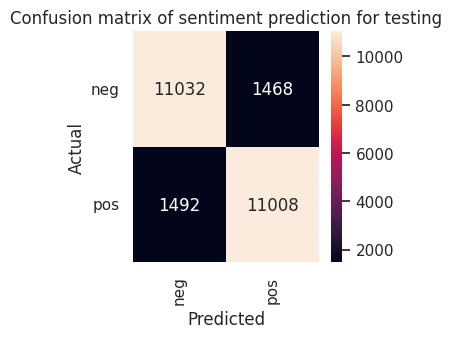

In [408]:
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

In [409]:
# get misclassified examples
missclass = [(item, y_proba[i]) for i, item in test_ds.unbatch().enumerate() if item[1] != y_pred[i]]

In [410]:
# output a few misclassified reviews
for item, pred in missclass[80:90]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b'Sergei Eisenstein\'s most famous movie has truly withstood the test of time. The story of a mutiny aboard a warship in 1905 does have the feeling of Soviet propaganda, but does a good job showing the conditions that led to the revolt. The scene on the Odessa steps should remain seared into anyone\'s mind.<br /><br />Okay, so "The Battleship Potemkin" wasn\'t actually the first movie to use montage, but they did a great job with it here. Certainly any film history class should show this movie. It\'s a great historical drama (although I will admit that I don\'t know how accurate it is). A 10/10.<br /><br />Oh, and we should have learned by now that "Potemkin" should be transliterated as "Potyomkin".', shape=(), dtype=string)
True label: 1 (pos)
Predicted probability of negative class: 0.6236637234687805, positive class: 0.3763362467288971

Review: tf.Tensor(b"Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, 

## Two-Stage Sentiment Extraction

In [13]:
# Load the zero-shot classification pipeline with the desired model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
input_text = "Burt Reynolds directed this action movie and (surprise!) he is actually a pretty good director. This movie starts off well as Burt's attempted bust of a drug dealer is botched, and he is demoted down to the vice squad. The ensemble cast has some pretty funny scenes as Brian Kieth is always eating something, Bernie Casey has more class than all of his co-workers combined, and Charles Durning loses control of his squad.<br /><br />The vice cops stumble on a high-priced call-girl ring that may have something to do with a series of murders. Sharkey spends days staking out Dominoe's (Rachel Ward) apartment, and starts to really adore her from afar.<br /><br />Just when they are getting close to the crime leader, Dominoe is murdered. I won't give away any of the surprises in the plot, but the first hour of this film is great.<br /><br />Unfortunately, the screenplay gets very clich\xc3\xa9d and unbelievable after that.<br /><br />Why would Burt Reynolds confront the crime boss with his big secret? Sure it makes the guy sweat, but it causes many more cops to be killed. And it is not believable that Dominoe and Sharkey would make love after they have know each other for one day, much less while their lives are in danger. And at the end, what happened to all the police that run into the building with our heroes? Isn't there a SWAT team? Also, the film never actually tells you how all of the bad guys are connected, and why they have to kill so many people.<br /><br />There is a very effective torture scene on a boat near the end of the film, which is probably the only really nail-biting scene of the film. It is a shame that the climax is a typical shoot-em-up. Still, this film is certainly entertaining if you like crime and action movies. Don't think about the plot holes, and you will have a good time."
class_descriptions = ["plot, script", "sounds, music", "directing", "acting", "video, visuals"]

input_text = "Might contain spoilers.<br /><br />This is just a good movie. Lots of good silly stuff to laugh at. However, do not watch the TV version, they cut to much out. Dom Deluise is rather awesome as the mafia Don who is hired to kill Robin. All I can say about his ten minutes: it's a long drive from Jersey. Also you gotta love them checking the script to make sure Robin gets another shot. Also: 12th Century Fox.<br /><br />Any bad stuff? The rappers at the beginning and the end seem rather out dated. The songs were rather lame. One time while watching this movie, I could think out a few more times when they could have thrown in another joke or 2. <br /><br />On the whole, however, an enjoyable movie experience. A must watch for comedy fans."
input_text = "Journalist Bob Woodward\'s blistering, scattershot and sometimes suspect account of actor John Belushi\'s rise and fall becomes a wholly misjudged movie, a nebulous 'fantasy' directed by Larry Peerce as if he were doing something edgy and vital. Michael Chiklis (years before his breakthrough on 'The Shield') is put in the unenviable position of portraying Belushi, taking a post-mortem trip through his life, recreating those 'Saturday Night Live' skits which are now part of TV history. It\'s like watching someone try to out-Lucy Lucille Ball--it can\'t be done. The reason why there was such sorrow at Belushi\'s death was because he was one of a kind. Chiklis makes a commendable attempt at looking the part, and he\'s funny in an early scene trying to escape from the morgue. Still, it\'s an uphill venture and no actor--no matter how talented--could have saved it. * from ****"
#input_text = "For one thing, he produced this movie. It has the feel of later movies with international casts that are dubbed. The opening credits tell us it was filmed in Vienna.<br /><br />Bey was a delight in the Universal adventure movies of the 1940s. He was also superb in a movie I saw maybe ten years ago but have never heard of since: 'The Amazing Mr. X.' Maybe it was Dr. X. I remember it as a thrilling and frightening movie.<br /><br />This one is pretty wooden, unfortunately. The plot isn\'t easy to follow. When I got the hang of it, I was disappointed anyway.<br /><br />Francis Lederer looks great as a concert pianist. He was a very handsome leading man ten or 15 years earlier. He never really caught on as a major star, though he should have.<br /><br />This isn\'t terrible but it\'s pretty heavy going."
#input_text = "Has some really good music and performances; Kid Creole and the Coconuts, James White and the Blacks, DNA, Tuxedo Moon, the Plastics, Melle Mel, Vincent Gallo, Lydia Lunch...etc, but aside from this there isn't much more to it. The dialog, especially the narration(by Saul Williams), is actually pretty good, but the performances are all pretty bland or outright bad, no matter how many hipsters are thrown in; Debbie Harry and Jean Micheal Basquit(the latter being the leading role) both still don't have enough cultural cred to keep this film from being a novelty item. It goes for the a Jack Kerouac style roving spontaneity, but doesn't have the insight to keep it moving along, which is where the band performances come in. I guess its pretty balanced in that regard between great music and bad acting, and I did enjoy it, but I just expected more. Though it does have a fairy tale ending."
#input_text = "This is a known fact, Mr. Seagal cannot smile, he can act, he can kick butt, there are faint smiles, no real smiles no laughing out loud and no real point of watching this confusing movie. We see an over weight Mr. Seagal as Dr. Wesley Maclaren, who is in desperate need of a haircut and his real daughter Ayako made an appearance as his office assistant. Story: Okay so Wesley lives in another darn outback with his sweet daughter Holly. They sit and enjoy their red flower tea and omelettes and on the other end of town some over weight militia leader decides to make the whole town sick by spreading a virus that travels by air and kills in a matter of 2 days thinking he can survive as he had an antidote. Problem, there is no antidote and the one that exists only holds back the virus for a while. The CIA are contacted and even they can't help and only one person isn't ill, Wesley's daughter Holly. So she gets hunted thinking the cure is in her blood. Wesley manages to grab his daughter and take her to her grandfather, who is a native indian. Together with his sister in law Ann they go to a base where there is a hidden lab to find a cure but even the soldiers there are dying slowly and so will others if they don't find a cure in time. And to shorten the moment, neither Ann or Wesley are infected by the virus...hmm. One weak fight scene. Terrible movie and all the men in it are in desperate need of a stair master."
#input_text = "We don't know if Darlene loves all three gentleman, certainly they are wary of one another, yet they live together. Viewers might surmise that the feelings of rivalry between the gentleman and the feelings of all of them toward Darlene might make for an unbearable home life.<br /><br />In the eerily beautiful rural Brazilian landscape (emphasized by the frequent use of polarization and the use of Kodachrome stock), anything might happen, and the alternatives for any one of them. save perhaps Ciro, may not be alluring enough to encourage them to change their circumstances. They seem to bear the intolerable because it is familiar-the unknown frightens them into complacency toward a fate which is more challenging than their characters can utilize. Thus it crushes them, rather than strengthening them. The web in which they are caught is made of the sanguine filaments which bind us all. Perhaps the sadness I felt after watching this movie has to do with it's portrayal of the inevitable fading of our youth's bright colors in the unforgiving light of time. The three children will enter the world fated to relive their parents lives to one or another degree. Well filmed and portrayed, the story is tragic in it's essence. Walt Disney it ain't"
#input_text = "David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does the perspective of the viewer.<br /><br />So is 'Homicide' which from the title tries to set the mind of the viewer to the usual crime drama. The principal characters are two cops, one Jewish and one Irish who deal with a racially charged area. The murder of an old Jewish shop owner who proves to be an ancient veteran of the Israeli Independence war triggers the Jewish identity in the mind and heart of the Jewish detective.<br /><br />This is were the flaws of the film are the more obvious. The process of awakening is theatrical and hard to believe, the group of Jewish militants is operatic, and the way the detective eventually walks to the final violent confrontation is pathetic. The end of the film itself is Mamet-like smart, but disappoints from a human emotional perspective.<br /><br />Joe Mantegna and William Macy give strong performances, but the flaws of the story are too evident to be easily compensated."

# Perform zero-shot classification
result = classifier(input_text, class_descriptions, multi_label=True)

# Print the results
print("Input Text:", input_text)
print("Classifications:")
for label, score in zip(result["labels"], result["scores"]):
    print(f"{label}: {score:.3f}")

Input Text: Journalist Bob Woodward's blistering, scattershot and sometimes suspect account of actor John Belushi's rise and fall becomes a wholly misjudged movie, a nebulous 'fantasy' directed by Larry Peerce as if he were doing something edgy and vital. Michael Chiklis (years before his breakthrough on 'The Shield') is put in the unenviable position of portraying Belushi, taking a post-mortem trip through his life, recreating those 'Saturday Night Live' skits which are now part of TV history. It's like watching someone try to out-Lucy Lucille Ball--it can't be done. The reason why there was such sorrow at Belushi's death was because he was one of a kind. Chiklis makes a commendable attempt at looking the part, and he's funny in an early scene trying to escape from the morgue. Still, it's an uphill venture and no actor--no matter how talented--could have saved it. * from ****
Classifications:
acting: 0.971
directing: 0.926
video, visuals: 0.411
sounds, music: 0.095
plot, script: 0.091

In [14]:
filt = np.array(result["scores"][:3]) > 0.3
top_topics = np.array(result["labels"][:3])[filt]
top_topics

print("Review:", input_text)
print("\nSentiment probabilities for the whole review:", tf.nn.sigmoid(model.predict(tf.constant([input_text]), verbose=0)).numpy())
for topic in top_topics:
    data = (tf.constant([input_text]), tf.constant([topic]))
    pred = tf.nn.sigmoid(model.predict(data, verbose=0))
    print(f"Sentiment probabilities for the {topic}: {pred.numpy()}")

Review: Journalist Bob Woodward's blistering, scattershot and sometimes suspect account of actor John Belushi's rise and fall becomes a wholly misjudged movie, a nebulous 'fantasy' directed by Larry Peerce as if he were doing something edgy and vital. Michael Chiklis (years before his breakthrough on 'The Shield') is put in the unenviable position of portraying Belushi, taking a post-mortem trip through his life, recreating those 'Saturday Night Live' skits which are now part of TV history. It's like watching someone try to out-Lucy Lucille Ball--it can't be done. The reason why there was such sorrow at Belushi's death was because he was one of a kind. Chiklis makes a commendable attempt at looking the part, and he's funny in an early scene trying to escape from the morgue. Still, it's an uphill venture and no actor--no matter how talented--could have saved it. * from ****


I0000 00:00:1708116592.391147    6938 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Sentiment probabilities for the whole review: [[0.3577419 0.6928649]]
Sentiment probabilities for the acting: [[0.5349737  0.51719254]]
Sentiment probabilities for the directing: [[0.36589524 0.6804651 ]]
Sentiment probabilities for the video, visuals: [[0.28606632 0.73787624]]


In [40]:
sample = train_ds.unbatch().take(3)
for review, label in sample:
    print("\n", review, label)


 tf.Tensor(b"Moonchild is a very difficult movie to categorise. It's easiest to think of it as several snapshots of the lives of the two central characters. The fact that these characters are members of a street gang set in an multicultural city of the near future and that one of them is a vampire does not preclude them from having moments like any other people, and this is one of the places where this movie is different to anything else I've ever heard of. It doesn't get wrapped up in the fact that one of the main characters is a vampire, it's just something that has to be dealt with like any other problem. The way the characters interact is surprisingly realistic- there are embarrassing relatives and tricks that are meant to look cool that just don't work, which leaves the film with a lovely sense of not taking itself too seriously for the most part.<br /><br />The other area that really stood out to me is the languages. The fictional city of Mallepa contains various cultural groups

In [41]:
review_label = [
    ("Moonchild is a very difficult movie to categorise. It's easiest to think of it as several snapshots of the lives of the two central characters. The fact that these characters are members of a street gang set in an multicultural city of the near future and that one of them is a vampire does not preclude them from having moments like any other people, and this is one of the places where this movie is different to anything else I've ever heard of. It doesn't get wrapped up in the fact that one of the main characters is a vampire, it's just something that has to be dealt with like any other problem. The way the characters interact is surprisingly realistic- there are embarrassing relatives and tricks that are meant to look cool that just don't work, which leaves the film with a lovely sense of not taking itself too seriously for the most part.<br /><br />The other area that really stood out to me is the languages. The fictional city of Mallepa contains various cultural groups, and characters speak the language that they would be expected to speak. Japanese gang members speak Japanese to each other, but Chinese when talking to characters of Chinese descent. Possibly the most amusing exchange involves an Australian and is conducted in English. The actors of the four arguably main characters have three separate mother tongues between them and speak varying levels of each others' languages, so it's quite a feat that the movie was made at all. Which, I suppose, brings me to the lead actors.<br /><br />Much has been made of the fact that the movie stars two of Japan's biggest rockstars, Gackt and Hyde, as well as Taiwanese superstar Lee-hom Wang, whether it is to praise them for their acting or criticise it or simply fangirl about them. In my opinion, Lee-hom is the best at playing a straight and realistic character. However, any lack of acting ability on Gackt's part is mostly masked by the fact that the character he plays is prone to being over-dramatic. I wasn't sure if Hyde's character was supposed to be as sulky and sarcastic as he came across, but it doesn't really detract from the movie either way.<br /><br />There are several scenes which take rather melodramatic turns, which made it difficult for them to affect me much emotionally (Although this doesn't seem to stop a lot of people). I found it's best to just enjoy the movie for what it is and not take it too seriously- It's perfect for getting out and watching with a group of friends. It does have its flaws, but overall it was very enjoyable and I'd highly recommend it to anyone who doesn't mind a few subtitles.",
    1),
    ("This movie was on the Romance channel, and I thought it might be a goofy 80\'s movie that would be enjoyable on some level, so my brother and I watched it. Boy did it suck. Boy gets crush on girl--correction, his *dream*-girl (apparently there is a difference; and I\'m surprised he realized she was his dream girl--he was smitten with her from over 30 feet away. I guess that just goes to show the power of dream-girls), boy ends up masquerading as a female to be near dream-girl (creative in the sense that it\'s a far-out plan, but un-creative in the sense that there are probably better solutions one might think up), awkward situations ensue, a match is made (all of which takes seems to take place around late afternoon--either the location was somehow responsible for this odd lighting, or the actors had to wait until they got off of their day-jobs to come to the set; I suspect the latter). Very clumsily done, very pathetic. It\'s almost never even amusing *accidentally*, so there really is nothing to redeem it. Unless you\'re interested in seeing Chad Lowe\'s early days, before he finally got his piece of the pie with his role as the HIV-positive gay guy on the series 'Life Goes On', or Gail O\'Grady who was on NYPD Blue and probably got to stare at Dennis Franz\'s buttocks). But those are unlikely motives--I\'d say 'systematic derangement of the senses' would be a more justified purpose. I\'m surprised I watched it all. I guess it\'s the kind of thing where, halfway through, you find yourself *still* watching due to some morbid, self-flagellistic inner-issue, and think you might as well finish it so you can tell your friends and family that you actually sat through such a horrible movie, on the off-chance that it\'ll garner you some sympathy for the questionable state of your mental health. Can *You* Take the Challenge?",
    0),
    ("This movie is all ultra-lightweight fluff, predictable from beginning to end. As a Don Knotts vehicle, 'The Incredible Mr. Limpet' was much better, with Knott\'s character there not nearly as incompetent or ignorant. His performance there was toned down, with none of his trademark goggle-eyed stare, although that may have something to do with him being replaced for most of the movie by a cartoon fish. Knotts made a living of playing the likable imbecile, much as Bob Denver did. Neither really seemed to be able to break out to other types of roles, assuming they were simply typecast. It was probably because of the slouch, the wild stare and the high-pitched voice. John Ritter, whom Knotts worked with in 'Three\'s Company,' was able to transcend his genre, branching out successfully into dramatic roles like 'The Dreamer of Oz,' but the closest Knotts ever got was a small role in 'Pleasantville.' Even Leslie Nielsen was a bad fit here, uncomfortably neither straight dramatic actor as he was at the time nor deadpan comedic actor as he later became in 'Airplane!' and 'Police Squad.'<br /><br />There\'s also no way the then-43 year-old Knotts could pass for a 35 year-old, as his character insisted he was. It was as ludicrously unbelievable as Tom Hanks at 38 playing the college-age Forrest Gump.<br /><br />The film was clearly made on a shoestring budget, very much looking like a hastily-filmed TV episode. It\'s especially evident in the 'exterior' scenes of the 'town' where Roy goes after he\'s fired. It\'s unlikely even a pre-schooler would be fooled by the Mayberry-like soundstage artificiality.<br /><br />Even viewing this strictly as a children\'s movie, it\'s very disappointing. It\'s not because it lacks action or special effects, although it does. The pace is much too slow, the situations repetitive. How many times can you watch Roy getting onto a bus? A comedy for kids should at least sometimes be madcap, with breakneck gags, otherwise you risk boring them (and any adults in the theater as well). Movies, even kid\'s movies, have improved quite a bit in the intervening decades. Even many contemporary comedies were better filmed and written. Disney\'s 'The Love Bug,' for instance, at least had some interesting race action.",
    0),
]

In [43]:
reviews = []
for review, label in review_label:
    #data = (tf.reshape(review, [1,]), tf.constant(["directing"]))
    result = classifier(review, class_descriptions, multi_label=True)

    # Print the results
    print("\nInput Text:", review)
    print("Classifications:")
    for label, score in zip(result["labels"], result["scores"]):
        print(f"{label}: {score:.3f}")


Input Text: Moonchild is a very difficult movie to categorise. It's easiest to think of it as several snapshots of the lives of the two central characters. The fact that these characters are members of a street gang set in an multicultural city of the near future and that one of them is a vampire does not preclude them from having moments like any other people, and this is one of the places where this movie is different to anything else I've ever heard of. It doesn't get wrapped up in the fact that one of the main characters is a vampire, it's just something that has to be dealt with like any other problem. The way the characters interact is surprisingly realistic- there are embarrassing relatives and tricks that are meant to look cool that just don't work, which leaves the film with a lovely sense of not taking itself too seriously for the most part.<br /><br />The other area that really stood out to me is the languages. The fictional city of Mallepa contains various cultural groups,

In [18]:
data

(<tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b"Journalist Bob Woodward's blistering, scattershot and sometimes suspect account of actor John Belushi's rise and fall becomes a wholly misjudged movie, a nebulous 'fantasy' directed by Larry Peerce as if he were doing something edgy and vital. Michael Chiklis (years before his breakthrough on 'The Shield') is put in the unenviable position of portraying Belushi, taking a post-mortem trip through his life, recreating those 'Saturday Night Live' skits which are now part of TV history. It's like watching someone try to out-Lucy Lucille Ball--it can't be done. The reason why there was such sorrow at Belushi's death was because he was one of a kind. Chiklis makes a commendable attempt at looking the part, and he's funny in an early scene trying to escape from the morgue. Still, it's an uphill venture and no actor--no matter how talented--could have saved it. * from ****"],
       dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=string, n

In [22]:
batch = (np.array(top_topics[i]) for i in range(len(top_topics)))

In [23]:
list(batch)

[array('acting', dtype='<U6'),
 array('directing', dtype='<U9'),
 array('video, visuals', dtype='<U14')]